In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


spark = SparkSession.builder.getOrCreate()

## Data Acquisition


In [2]:
# Read in CSV file 
source = (spark.read.csv("source.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [3]:
# Read in CSV file 
case = (spark.read.csv("case.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [4]:
# Read in CSV file 
dept = (spark.read.csv("dept.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [5]:
source.show(5) ## <-- previewing source

+---------+----------------+
|source_id| source_username|
+---------+----------------+
|   100137|Merlene Blodgett|
|   103582|     Carmen Cura|
|   106463| Richard Sanchez|
|   119403|  Betty De Hoyos|
|   119555|  Socorro Quiara|
+---------+----------------+
only showing top 5 rows



In [6]:
case.show(3, False, True) ## <-- previewing case

-RECORD 0-----------------------------------------------------
 case_id              | 1014127332                            
 case_opened_date     | 1/1/18 0:42                           
 case_closed_date     | 1/1/18 12:29                          
 SLA_due_date         | 9/26/20 0:42                          
 case_late            | NO                                    
 num_days_late        | -998.5087616000001                    
 case_closed          | YES                                   
 dept_division        | Field Operations                      
 service_request_type | Stray Animal                          
 SLA_days             | 999.0                                 
 case_status          | Closed                                
 source_id            | svcCRMLS                              
 request_address      | 2315  EL PASO ST, San Antonio, 78207  
 council_district     | 5                                     
-RECORD 1----------------------------------------------

In [7]:
dept.show(5) ## <-- previewing departments

+--------------------+--------------------+----------------------+-------------------+
|       dept_division|           dept_name|standardized_dept_name|dept_subject_to_SLA|
+--------------------+--------------------+----------------------+-------------------+
|     311 Call Center|    Customer Service|      Customer Service|                YES|
|               Brush|Solid Waste Manag...|           Solid Waste|                YES|
|     Clean and Green|Parks and Recreation|    Parks & Recreation|                YES|
|Clean and Green N...|Parks and Recreation|    Parks & Recreation|                YES|
|    Code Enforcement|Code Enforcement ...|  DSD/Code Enforcement|                YES|
+--------------------+--------------------+----------------------+-------------------+
only showing top 5 rows



In [8]:
## inspecting our spark dataframe date types using dtypes

case.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'string'),
 ('case_closed_date', 'string'),
 ('SLA_due_date', 'string'),
 ('case_late', 'string'),
 ('num_days_late', 'double'),
 ('case_closed', 'string'),
 ('dept_division', 'string'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'int')]

In [9]:
dept.dtypes

[('dept_division', 'string'),
 ('dept_name', 'string'),
 ('standardized_dept_name', 'string'),
 ('dept_subject_to_SLA', 'string')]

In [10]:
source.dtypes

[('source_id', 'string'), ('source_username', 'string')]

### Data Preparation

Things to do:

Rename Columns:
* 'SLA_due_date -> case_due_date

Correct Data Types:
* case_closed and case_late to boolean
* council_district as a string
* case_opened_date, case_closed_date and case_due_date to datetime format

Data Transformation:
* request_address: trim and lowercase
* format council district with leading zeros
* convert the number of days a case is late to a number of weeks

New features:
* zip_code : extract from address
* case_age
* days_to_closed
* case_lifetime

Join cases data with department data:

In [11]:
# Rename 'SLA_due_date' to 'case_due_date' using .withColumnRenamed

case = case.withColumnRenamed('SLA_due_date', 'case_due_date')

In [12]:
case.show(1, truncate = False, vertical = True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 1/1/18 0:42                          
 case_closed_date     | 1/1/18 12:29                         
 case_due_date        | 9/26/20 0:42                         
 case_late            | NO                                   
 num_days_late        | -998.5087616000001                   
 case_closed          | YES                                  
 dept_division        | Field Operations                     
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 5                                    
only showing top 1 row



Correct Data Types:

In [13]:
# correct data types: case_closed and case_late to boolean

case.select("case_closed", "case_late").show(5)

+-----------+---------+
|case_closed|case_late|
+-----------+---------+
|        YES|       NO|
|        YES|       NO|
|        YES|       NO|
|        YES|       NO|
|        YES|      YES|
+-----------+---------+
only showing top 5 rows



In [14]:
# use .withColumn to change columns from string to boolean values

case = case.withColumn('case_closed', expr('case_closed == "YES"'))\
.withColumn('case_late', expr('case_late == "YES"'))

In [15]:
case.select("case_closed", "case_late").show(5)

+-----------+---------+
|case_closed|case_late|
+-----------+---------+
|       true|    false|
|       true|    false|
|       true|    false|
|       true|    false|
|       true|     true|
+-----------+---------+
only showing top 5 rows



In [16]:
# council_district cast as string
case.select('council_district').show(4)

+----------------+
|council_district|
+----------------+
|               5|
|               3|
|               3|
|               3|
+----------------+
only showing top 4 rows



In [17]:
# council_district as a string instead of int
case = case.withColumn('council_district', col('council_district').cast('string'))

In [18]:
# view the column

case.select('council_district').show(4)

+----------------+
|council_district|
+----------------+
|               5|
|               3|
|               3|
|               3|
+----------------+
only showing top 4 rows



In [19]:
# check datatypes
case.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'string'),
 ('case_closed_date', 'string'),
 ('case_due_date', 'string'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('dept_division', 'string'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string')]

In [20]:
# convert case_opened_date, case_closed_date and case_due_date to datetime format

case.select('case_opened_date', 'case_closed_date', 'case_due_date').show(5)

+----------------+----------------+-------------+
|case_opened_date|case_closed_date|case_due_date|
+----------------+----------------+-------------+
|     1/1/18 0:42|    1/1/18 12:29| 9/26/20 0:42|
|     1/1/18 0:46|     1/3/18 8:11|  1/5/18 8:30|
|     1/1/18 0:48|     1/2/18 7:57|  1/5/18 8:30|
|     1/1/18 1:29|     1/2/18 8:13| 1/17/18 8:30|
|     1/1/18 1:34|    1/1/18 13:29|  1/1/18 4:34|
+----------------+----------------+-------------+
only showing top 5 rows



In [21]:
# to_timestamp, fmt

fmt = "M/d/yy H:mm"

case = case.withColumn('case_opened_date', to_timestamp('case_opened_date', fmt))\
.withColumn('case_closed_date', to_timestamp('case_closed_date', fmt))\
.withColumn('case_due_date', to_timestamp('case_due_date', fmt))

In [22]:
# check the three columns again

case.select('case_opened_date', 'case_closed_date', 'case_due_date').show(5)

+-------------------+-------------------+-------------------+
|   case_opened_date|   case_closed_date|      case_due_date|
+-------------------+-------------------+-------------------+
|2018-01-01 00:42:00|2018-01-01 12:29:00|2020-09-26 00:42:00|
|2018-01-01 00:46:00|2018-01-03 08:11:00|2018-01-05 08:30:00|
|2018-01-01 00:48:00|2018-01-02 07:57:00|2018-01-05 08:30:00|
|2018-01-01 01:29:00|2018-01-02 08:13:00|2018-01-17 08:30:00|
|2018-01-01 01:34:00|2018-01-01 13:29:00|2018-01-01 04:34:00|
+-------------------+-------------------+-------------------+
only showing top 5 rows



Data Transformation

In [23]:
# request_address: trim and lowercase

case.select('request_address').show(5, False)

+-------------------------------------+
|request_address                      |
+-------------------------------------+
|2315  EL PASO ST, San Antonio, 78207 |
|2215  GOLIAD RD, San Antonio, 78223  |
|102  PALFREY ST W, San Antonio, 78223|
|114  LA GARDE ST, San Antonio, 78223 |
|734  CLEARVIEW DR, San Antonio, 78228|
+-------------------------------------+
only showing top 5 rows



In [24]:
case = case.withColumn('request_address', trim(lower(case.request_address)))

case.select('request_address').show(5, False)

+-------------------------------------+
|request_address                      |
+-------------------------------------+
|2315  el paso st, san antonio, 78207 |
|2215  goliad rd, san antonio, 78223  |
|102  palfrey st w, san antonio, 78223|
|114  la garde st, san antonio, 78223 |
|734  clearview dr, san antonio, 78228|
+-------------------------------------+
only showing top 5 rows



In [25]:
# convert the number of days a case is late to a number of weeks

case = case.withColumn('num_weeks_late', expr('num_days_late/7'))

case.select("num_days_late", "num_weeks_late").show(5)

+-------------------+--------------------+
|      num_days_late|      num_weeks_late|
+-------------------+--------------------+
| -998.5087616000001|        -142.6441088|
|-2.0126041669999997|-0.28751488099999994|
|       -3.022337963|-0.43176256614285713|
|       -15.01148148| -2.1444973542857144|
|0.37216435200000003|         0.053166336|
+-------------------+--------------------+
only showing top 5 rows



In [26]:
# use format_string function to pad zeros for council_district

case = case.withColumn('council_district', format_string('%03d', col('council_district').cast('int')))

In [27]:
case.select('council_district').show(5)

+----------------+
|council_district|
+----------------+
|             005|
|             003|
|             003|
|             003|
|             007|
+----------------+
only showing top 5 rows



New Features: 

In [28]:
# create a new column for zipcode:

case = case.withColumn('zipcode', regexp_extract('request_address', r"(\d+$)", 1))

case.select('zipcode').show(5)

+-------+
|zipcode|
+-------+
|  78207|
|  78223|
|  78223|
|  78223|
|  78228|
+-------+
only showing top 5 rows



In [29]:
case.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 dept_division        | Field Operations                     
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode

case_age: How old the case is; the difference in days between when the case was opened and the current day

days_to_closed: The number of days between when the case was opened and when it was closed

case_lifetime: Number of days between when the case was opened and when it was closed, if the case is still open, the number of days since the case was opened

In [30]:
#create three new columns 'case_age', 'days_to_closed', 'case_lifetime'

case = (
    case.withColumn(
        "case_age", datediff(current_timestamp(), "case_opened_date")
    )
    .withColumn(
        "days_to_closed", datediff("case_closed_date", "case_opened_date")
    )
    .withColumn(
        "case_lifetime",
        when(expr("! case_closed"), col("case_age")).otherwise(
            col("days_to_closed")
        ),
    )
)

In [31]:
case.select(expr('CASE WHEN case_closed == False THEN case_age ELSE days_to_closed END').alias('case_lifetime')).show(3)

+-------------+
|case_lifetime|
+-------------+
|            0|
|            2|
|            1|
+-------------+
only showing top 3 rows



In [32]:
case.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 dept_division        | Field Operations                     
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode

Joining dept on case

In [33]:
# join the df and dept dataframe using 'dept_division' as common key
# drop columns as needed (keep standardized_dept_name)
# convert dept_subject_to_SLA to boolean

case = (
    case
    # left join on dept_division
    .join(dept, "dept_division", "left")
    # drop all the columns except for standardized name, as it has much fewer unique values
    .drop(dept.dept_division)
    .drop(dept.dept_name)
    .drop(case.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    # convert to a boolean
    .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
)

### Spark Display: TOC click reference

In [34]:
case.show(1, False, True) ## <-- previewing our new dataframe

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

### Data Exploration

#### Question 1: How many different cases are there, by department?

In [73]:
## grouping by department and counting and showing 

case.groupBy("department").count().show(truncate = False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |279270|
|Animal Care Services    |116915|
|Trans & Cap Improvements|96193 |
|Parks & Recreation      |19907 |
|Customer Service        |2849  |
|Metro Health            |5163  |
|City Council            |33    |
|DSD/Code Enforcement    |321374|
+------------------------+------+



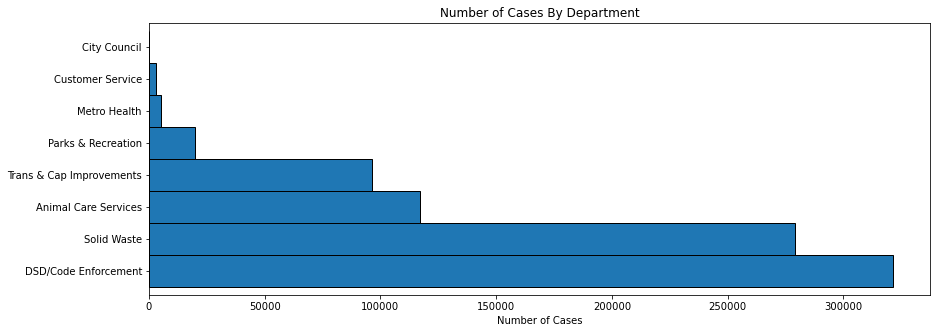

In [36]:
## first we use aggregationg with spark

(
    case.groupBy("department")
    .count()
    .toPandas()  ## then we pass to pandas for vis purposes
    .set_index("department")["count"] ## set department as index
    .sort_values(ascending=False) ## sort for vis purposes
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5)) ## uses pandas plot bar horizontal
) 

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")
None

#### Question 2: Does the percentage of cases that are late vary by department?


In [37]:
## filtering for all late cases by department

(
case.where(case.case_late == 'true').groupby('department').count().show()
)

+--------------------+-----+
|          department|count|
+--------------------+-----+
|         Solid Waste|32945|
|Animal Care Services|23276|
|Trans & Cap Impro...| 5411|
|  Parks & Recreation| 3797|
|    Customer Service| 2010|
|        Metro Health|  829|
|DSD/Code Enforcement|26235|
+--------------------+-----+



In [38]:
## finding total amount of late cases

case.where(case.case_late == 'true').count()

94503

In [39]:
## making our pandas dataframe from spark 
q2 = (
    case.where(case.case_late == 'true').groupby('department').count()
    .toPandas()
    
)
q2 = q2.set_index('department') ## setting departmnet as index

q2 ## previewing our pandas dataframe

,count
department,
Solid Waste,32945
Animal Care Services,23276
Trans & Cap Improvements,5411
Parks & Recreation,3797
Customer Service,2010
Metro Health,829
DSD/Code Enforcement,26235


In [40]:
q2['count'] = (q2['count'] / 94503) * 100 ## creating our percentages using total case count

q2

,count
department,
Solid Waste,34.861327
Animal Care Services,24.629906
Trans & Cap Improvements,5.725744
Parks & Recreation,4.017862
Customer Service,2.126917
Metro Health,0.877221
DSD/Code Enforcement,27.761023


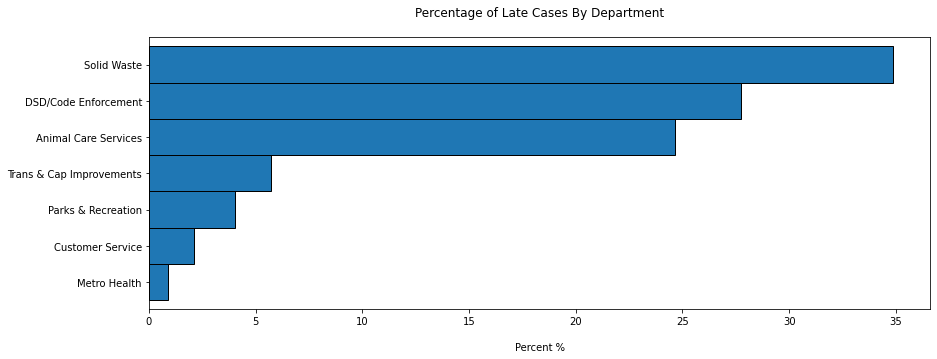

In [47]:
## sorting the percentages and using pandas bar to visualize the different percentages

q2.sort_values(by = 'count').plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)

plt.title("Percentage of Late Cases By Department\n")
plt.ylabel("")
plt.xlabel("\nPercent %")
None

#### Question 3: On average, how late are the late cases by department?


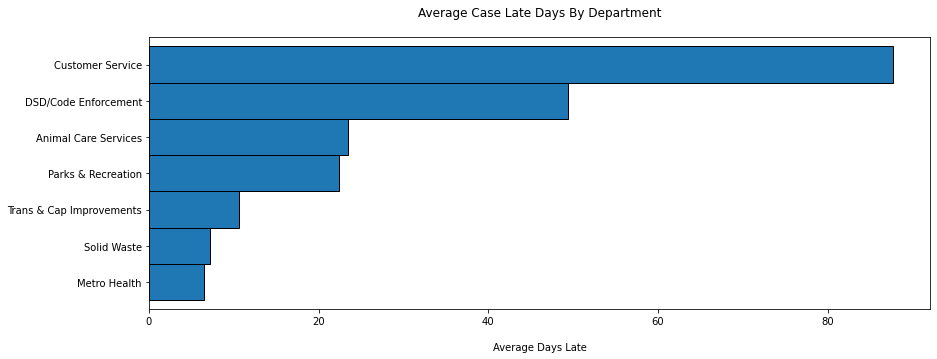

In [52]:

(
    ## filtering for late cases
    case.where(case.case_late == 'true')
    
    ## grouping by department
    .groupBy("department")
    
    ## aggregating for the average of days late and creating a avg_days_late column
    .agg(mean("num_days_late").alias("avg_days_late"))
    
    ## passing to pandas
    .toPandas()
    
    ## setting index as department
    .set_index("department")
    
    ## sorting for cleaner viz
    .avg_days_late.sort_values(ascending=True)
    
    ## using pandas plot barh
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Average Case Late Days By Department\n")
plt.ylabel("")
plt.xlabel("\nAverage Days Late")
None

#### Question 4: What is the service type that is the most late? Just for Parks & Rec?


In [54]:
## previewing our spark.show

(
    ## filtering for park and rec department
    case.where(case.department == 'Parks & Recreation')
    
    ## filtering for late cases
    .where(case.case_late == 'true')
    
    ## grouping by service type counting and showing
    .groupby('service_request_type')
    .count().show()
)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|        Tree Removal|   84|
|    Sign Maintenance|   34|
|Park Building Mai...|   23|
|General Building ...|  105|
|Major Park Improv...|   17|
|Indoor Janitorial...|    5|
|Outdoor Trash/Mut...|   21|
| Sportfield Lighting|  268|
|Small Equipment R...|    6|
|Miscellaneous Par...|   43|
|Lake/Pond Mainten...|    7|
|Landscape Mainten...|   19|
|        Parks Mowing|   34|
|     Heavy Equipment|   19|
|Amenity Park Impr...|   25|
|          Irrigation|    3|
|    Pool Maintenance|   12|
|        Graffiti Int|  255|
|Brush/Debris Coll...|   47|
|Tree Trimming/Mai...|  171|
+--------------------+-----+
only showing top 20 rows



In [56]:
## making our pandas dataframe after filtering and grouping for the scope of the question

q4 = (
    case.where(case.department == 'Parks & Recreation')
    .where(case.case_late == 'true')
    .groupby('service_request_type')
    .count()
    
    ## converting to pandas
    .toPandas().set_index('service_request_type')
)
q4.head(5) ## previewing pandas df

,count
service_request_type,
Tree Removal,84
Sign Maintenance,34
Park Building Maint Invest,23
General Building Maintenance,105
Major Park Improvement Install,17


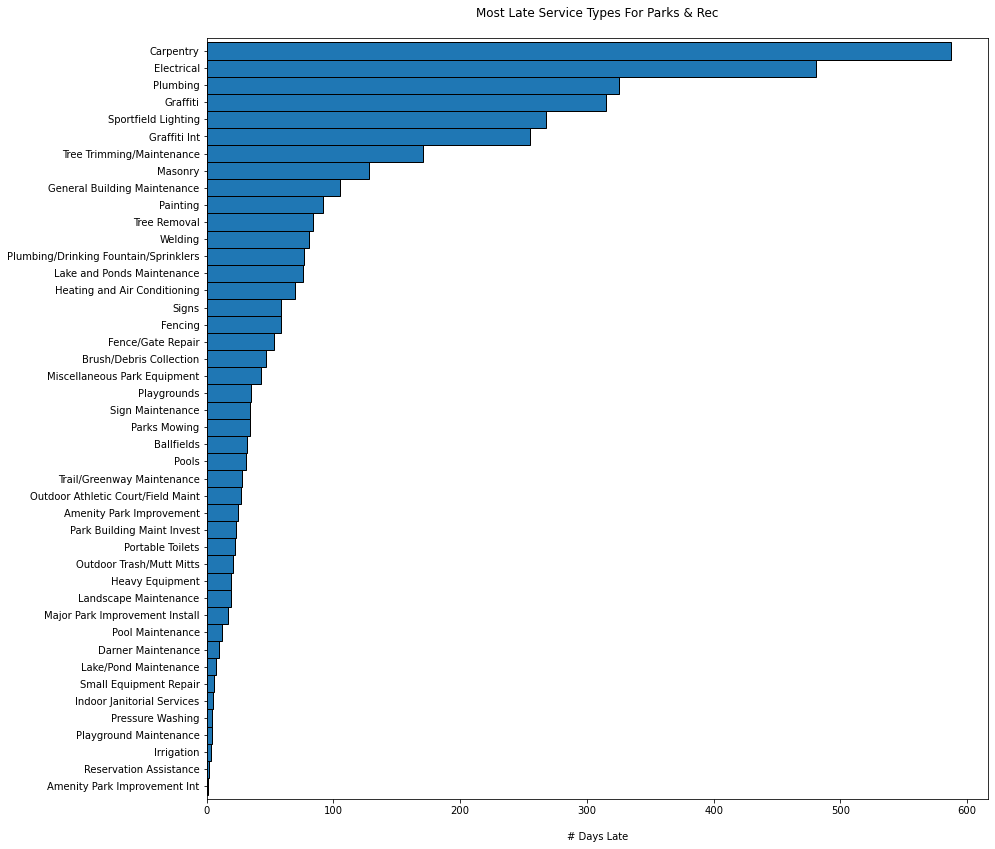

In [61]:
## sorting the count column and using pandas bar to visualize the different
## days late for each service from parks & rec

q4.sort_values(by = 'count').plot.barh(width=1, edgecolor="black", figsize=(14, 14), 
                                      legend = False)

plt.title("Most Late Service Types For Parks & Rec\n")
plt.ylabel("")
plt.xlabel("\n# Days Late")
None

#### Question 5: For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

##### DSD Code Enforcement Service Requests

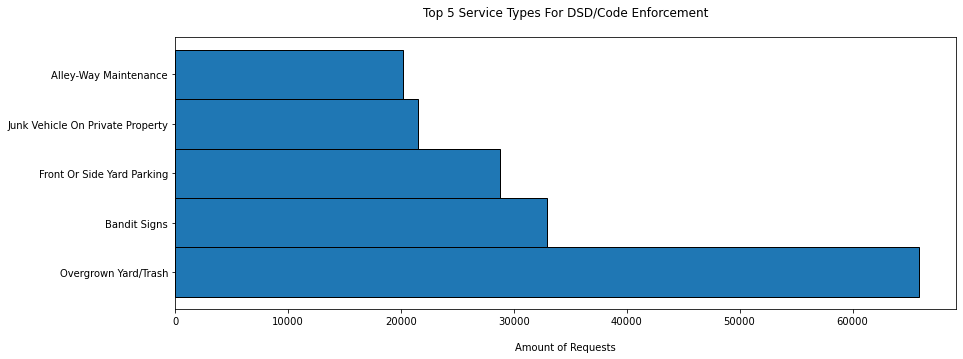

In [68]:
q5 = (
    ## filtering for DSD department
    case.where(case.department == 'DSD/Code Enforcement')
    
    ## grouping by service type counting and showing
    .groupby('service_request_type')
    .count()
    
    ## converting to pandas and setting index to request type
    .toPandas().set_index('service_request_type')
)
(
    q5.sort_values(by = 'count', ascending = False).head(5)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Top 5 Service Types For DSD/Code Enforcement\n")
plt.ylabel("")
plt.xlabel("\nAmount of Requests")
None

##### Solid Waste Service Requests

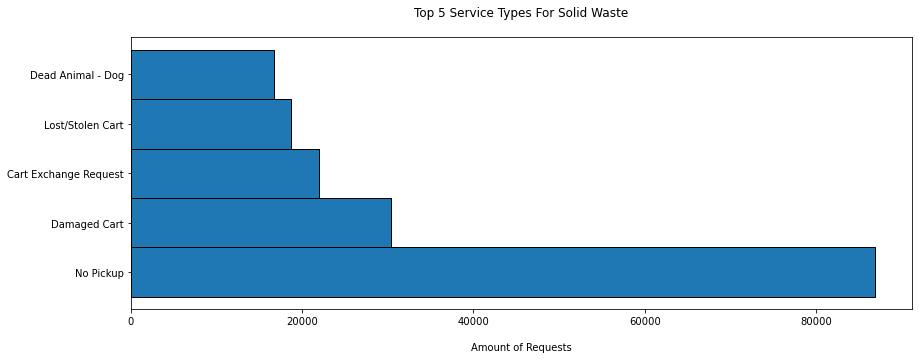

In [69]:
sw = (
    ## filtering for solid waste department
    case.where(case.department == 'Solid Waste')
    
    ## grouping by service type counting and showing
    .groupby('service_request_type')
    .count()
    
    ## converting to pandas and setting index to request type
    .toPandas().set_index('service_request_type')
)
(
    sw.sort_values(by = 'count', ascending = False).head(5)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Top 5 Service Types For Solid Waste\n")
plt.ylabel("")
plt.xlabel("\nAmount of Requests")
None

##### Animal Care Services Service Requests

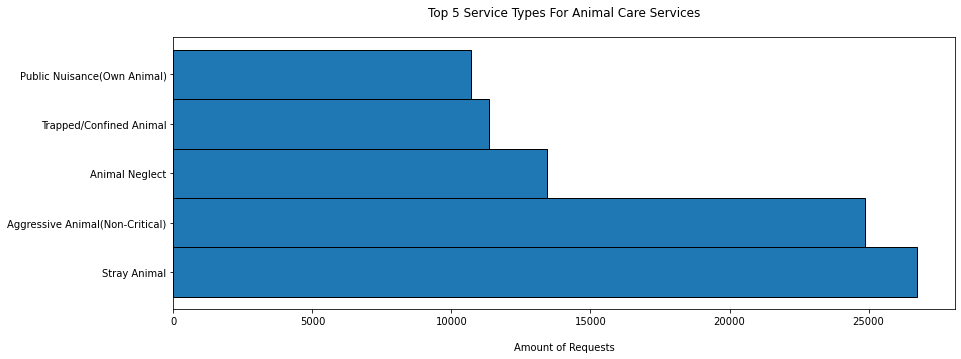

In [72]:
acs = (
    ## filtering for Animal Care department
    case.where(case.department == 'Animal Care Services')
    
    ## grouping by service type counting and showing
    .groupby('service_request_type')
    .count()
    
    ## converting to pandas and setting index to request type
    .toPandas().set_index('service_request_type')
)
(
    acs.sort_values(by = 'count', ascending = False).head(5)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Top 5 Service Types For Animal Care Services\n")
plt.ylabel("")
plt.xlabel("\nAmount of Requests")
None

##### Customer Service Service Requests

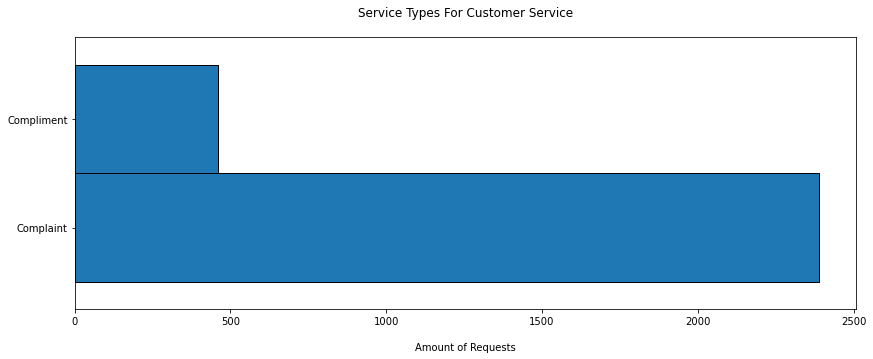

In [76]:
cs = (
    ## filtering for Customer Service department
    case.where(case.department == 'Customer Service')
    
    ## grouping by service type counting and showing
    .groupby('service_request_type')
    .count()
    
    ## converting to pandas and setting index to request type
    .toPandas().set_index('service_request_type')
)
(
    cs.sort_values(by = 'count', ascending = False).head(5)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Service Types For Customer Service\n")
plt.ylabel("")
plt.xlabel("\nAmount of Requests")
None

#### Question 6: Does whether or not its a weekend matter for when a case is opened/closed?


In [85]:
case = case.withColumn('weekday_open_day', date_format('case_opened_date', 'E'))

case.show(1, False, True) ## <-- previewing our new dataframe

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

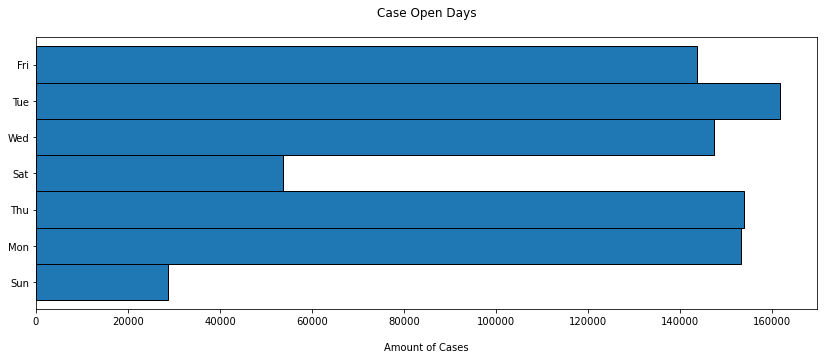

In [88]:
(
    ## grouping by weekday column and counting the cases per weekday
    case.groupby('weekday_open_day').count()
    
    ## converting to pandas and setting the index to weekday
    .toPandas().set_index('weekday_open_day')
    
    ## using pandas .plot bar to plot the bar graph
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Case Open Days\n")
plt.ylabel("")
plt.xlabel("\nAmount of Cases")
None

In [87]:
case = case.withColumn('weekday_close_day', date_format('case_closed_date', 'E'))

case.show(1, False, True) ## <-- previewing our new dataframe

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

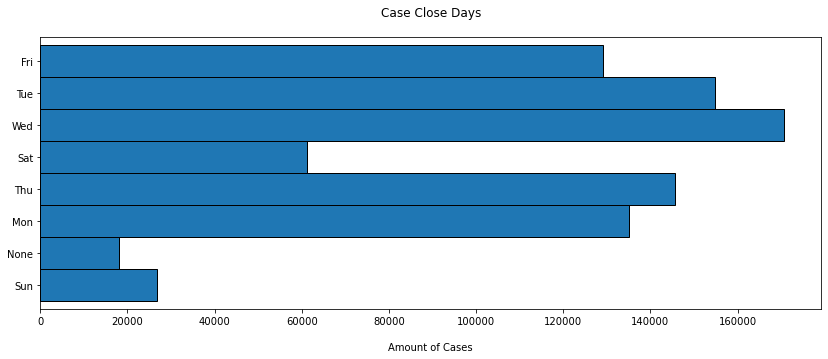

In [89]:
(
    ## grouping by weekday column and counting the cases per weekday
    case.groupby('weekday_close_day').count()
    
    ## converting to pandas and setting the index to weekday
    .toPandas().set_index('weekday_close_day')
    
    ## using pandas .plot bar to plot the bar graph
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5), 
                                      legend = False)
)
plt.title("Case Close Days\n")
plt.ylabel("")
plt.xlabel("\nAmount of Cases")
None

#### Question 7: On average, how many cases are opened a day for the Customer Service department?


In [93]:
(
    case.where(case.department == 'Customer Service')
    
    ## grouping by weekday column and counting the cases per weekday
    .groupby('case_opened_date').count().agg(mean('count')).show()    
)


+------------------+
|        avg(count)|
+------------------+
|1.0060028248587571|
+------------------+



#### Question 8: Does the number of service requests for the solid waste department vary by day of the week?

In [ ]:
(
    case.where(case.department == 'Solid Waste')
    .groupby('weekday').count()
    .toPandas().set_index('weekday')
)